In [1]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [3]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = np.array([a[k]*np.exp(1j*phi[k]) for k in range(len(a))])
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [4]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [5]:
IPython.display.Audio('ClocheB.WAV')

In [6]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

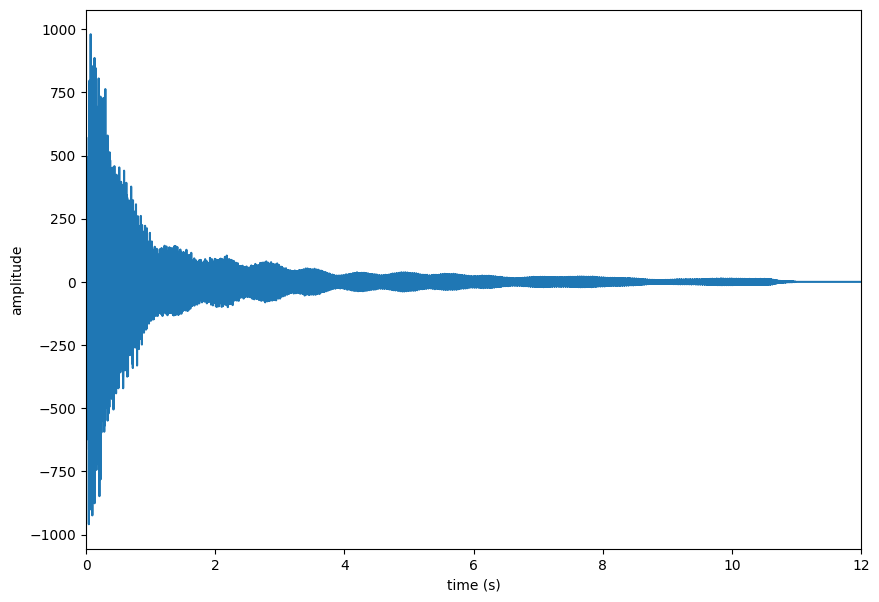

In [7]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [8]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

# 3. Synthetic Signal 

[1.5118710507505337, 1.068999595936]

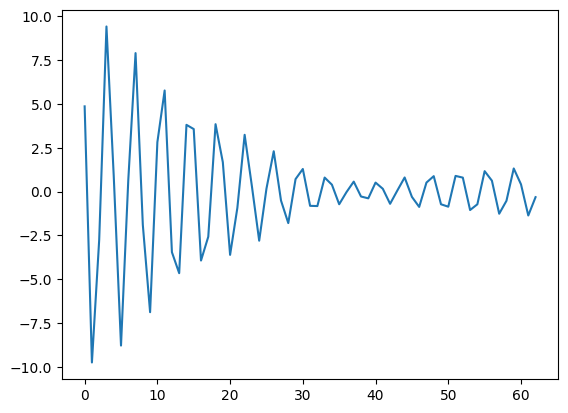

In [9]:
delta = np.array([0,-0.05])
N=63
f=np.array([1/4,1/4+1/N])
a=np.array([1,10])
phi=[np.random.uniform(-np.pi,np.pi),np.random.uniform(-np.pi,np.pi)]
x=Synthesis(N,delta,f,a,phi)
plt.plot(np.real(x))
phi



# 3.1 Spectral analysis by Fourier transform

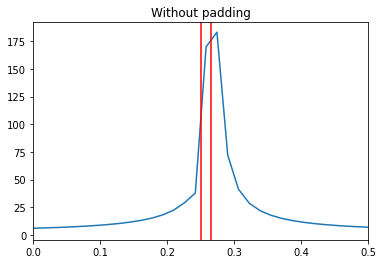

In [11]:
fig, ax = plt.subplots()
plt.xlim([0,0.5])
ax.plot(np.linspace(0,1,len(x)),np.abs(np.fft.fft(x)))
ax.axvline(x=1/4, color='red')
ax.axvline(x=1/4+1/N, color='red')
plt.title("Without padding")
plt.show()

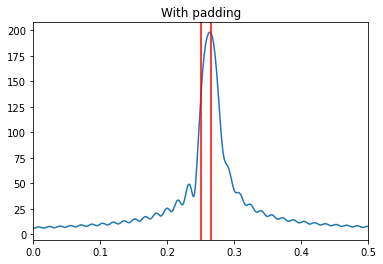

In [12]:
x_bis=np.concatenate((x,np.zeros(1024-len(x))))
fig, ax = plt.subplots()
plt.xlim([0,0.5])
ax.plot(np.linspace(0,1,len(x_bis)),np.abs(np.fft.fft(x_bis)))
ax.axvline(x=1/4, color='red')
ax.axvline(x=1/4+1/N, color='red')
plt.title("With padding")
plt.show()

Même si le spectre est plus précis avec padding dans les eux cas on ne peut distinguer les pics aux frequence séparer de 1/N via fourier, avec N la longueur du signal.

# 3.2 High Resolution methods

## 1.

In [13]:
n=32
K=2
l=N+1-n
H=hankel(x[:n],x[n-1:])
Rxx=(1/l)*H@H.conj().T



## 2. 

In [14]:
[U1,Lambda,U2] = np.linalg.svd(Rxx)
W=U1[:,:2]


# 3.2.1

## 3. 

In [10]:
W_up=W[1:,:]
W_down=W[:n-1,:]
phi_matrice=((np.linalg.inv(W_down.conj().T@W_down))@W_down.conj().T)@W_up
valeur_propre_phi=np.linalg.eig(phi_matrice)[0]

delta_estime=np.log(np.abs(valeur_propre_phi))
f_estime=(1/(2*np.pi))*np.abs(np.array([atan(np.imag(valeur_propre_phi[k])/np.real(valeur_propre_phi[k])) for k in range(len(valeur_propre_phi))]))
delta_estime,f_estime


NameError: name 'W' is not defined

# 4.

In [16]:
def LeastSquares(x,delta,f):
    ln_VN=np.outer(np.arange(N),np.array([delta[k]+2*1j*np.pi*f[k] for k in range(K)]))
    VN=np.exp(ln_VN)
    alpha= (np.linalg.inv(VN.conj().T@VN)@VN.conj().T)@x
    return [np.abs(alpha),np.abs(np.array([atan(np.imag(alpha[k])/np.real(alpha[k])) for k in range(len(valeur_propre_phi))]))]

LeastSquares(x,delta_estime,f_estime)

[array([4.64314837, 2.35932494]), array([0.90963412, 0.0411477 ])]

# 5.

In [17]:
print( "L'écart relatifs sur les fréquences est : ", np.abs((f_estime-f)/f))
print("L'écart relatifs sur les atténuations est : ", np.abs((delta_estime-delta)))
[a_estime,phi_estime]=LeastSquares(x,delta_estime,f_estime)
print("L'écart relatifs sur les amplitudes est : ", np.abs((a_estime-a)/a))
print("L'écart relatifs sur les phases est : ", np.abs((phi_estime-phi)/phi))

L'écart relatifs sur les fréquences est :  [0.06349206 0.05970149]
L'écart relatifs sur les atténuations est :  [0.05 0.05]
L'écart relatifs sur les amplitudes est :  [3.64314837 0.76406751]
L'écart relatifs sur les phases est :  [1.31951012 0.97223934]


Esprit permet de distinguer deux pics de fréquences dans le signal à l'instar de Fourrier mais il y'a des imprecisions dans l'évalution des différents paramètres. Je pense que la source d'erreur principale provient de la recherche des valeur propre. 

# 3.2.2 

In [12]:
def vn(d,f,n):
    ln_vn=d+2*1j*np.pi*f*np.arange(n)
    return np.exp(ln_vn)

def MUSIC(x,n,K):
    W_noise=U1[:,2:]
    fr=np.linspace(0,1,100)
    delt=np.linspace(-0.1,0.1,100)
    res=np.zeros((len(delt),len(fr)))
    for i in range(len(res)):
        for j in range(len(res[0])):
            res[i][j]=1/np.linalg.norm(W_noise.conj().T@vn(delt[i],fr[j],n))
    
    fig = plt.figure(figsize=(10,10))
    #delt,fr=np.meshgrid(delt,fr)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(delt, fr, res)
    ax.set_xlabel('Delta')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('MUSIC spectrum')
    ax.set_title('MUSIC algorithm')
    plt.show()

MUSIC(x,n,K)


NameError: name 'n' is not defined

# 4. Audio Signals

# 4.1 

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=95997, comptype='NONE', compname='not compressed')


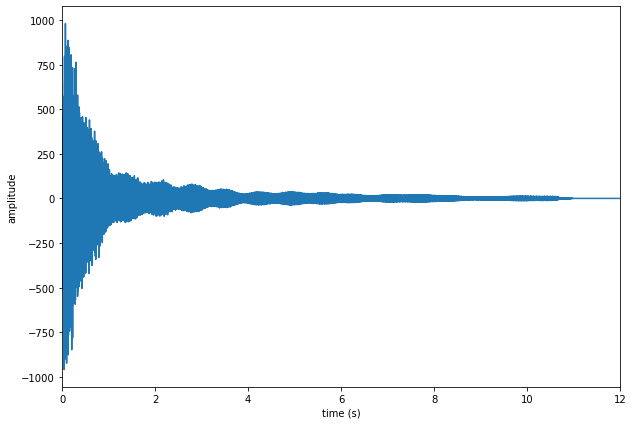

In [19]:
## Cloche A
wavefile = load_sound('ClocheA.WAV')
print(wavefile.getparams())
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)


In [23]:
X=np.abs(np.fft.fft(x))
plt.plot(np.linspace(0,Fs,len(X)),X)

 ...]

Error in callback <function flush_figures at 0x7f81b5845e50> (for post_execute):


KeyboardInterrupt: 